# Rays3 - DE Project

### Dataset Description
Link: https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#610146
#### Transaction Table
It contains money transfer and also other gifting goods and service, like you booked a ticket for others, etc.

`TransactionDT`: timedelta from a given reference datetime (not an actual timestamp)

“TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so I think the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 183.”

`TransactionAMT`: transaction payment amount in USD

“Some of the transaction amounts have three decimal places to the right of the decimal point. There seems to be a link to three decimal places and a blank addr1 and addr2 field. Is it possible that these are foreign transactions and that, for example, the 75.887 in row 12 is the result of multiplying a foreign currency amount by an exchange rate?”

`ProductCD`: product code, the product for each transaction

“Product isn't necessary to be a real 'product' (like one item to be added to the shopping cart). It could be any kind of service.”

`card1 - card6`: payment card information, such as card type, card category, issue bank, country, etc.

`addr`: address

“both addresses are for purchaser
- addr1 as billing region
- addr2 as billing country”

`dist`: distance
"distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.”

`P_ and (R__) emaildomain`: purchaser and recipient email domain

“ certain transactions don't need recipient, so R_emaildomain is null.”

`C1-C14`: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

“Example like counts of phone numbers, email addresses, names associated with the user, device, ipaddr, billingaddr, etc. Also these are for both purchaser and recipient, which doubles the number.”

`D1-D15`: timedelta, such as days between previous transaction, etc.

`M1-M9`: match, such as names on card and address, etc.

`Vxxx`: Vesta engineered rich features, including ranking, counting, and other entity relations.

“For example, how many times the payment card associated with a IP and email or address appeared in 24 hours time range, etc.”
"All Vesta features were derived as numerical. some of them are count of orders within a clustering, a time-period or condition, so the value is finite and has ordering (or ranking). I wouldn't recommend to treat any of them as categorical. If any of them resulted in binary by chance, it maybe worth trying."

#### Identity Table
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

`id01 to id38` are numerical features for identity, which is collected by Vesta and security partners such as device rating, ip_domain rating, proxy rating, etc. Also it recorded behavioral fingerprint like account login times/failed to login times, how long an account stayed on the page, etc. All of these are not able to elaborate due to security partner T&C.

##### Labeling logic
The logic of our labeling is define reported chargeback on the card as fraud transaction (isFraud=1) and transactions posterior to it with either user account, email address or billing address directly linked to these attributes as fraud too. If none of above is reported and found beyond 120 days, then we define as legit transaction (isFraud=0).

### Downloading Dataset

Source - https://www.kaggle.com/competitions/ieee-fraud-detection/data

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! rm -r ~/.kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c ieee-fraud-detection

 93% 110M/118M [00:00<00:00, 170MB/s] 
100% 118M/118M [00:00<00:00, 162MB/s]


In [ ]:
! cp ieee-fraud-detection.zip /content/drive/MyDrive/DE-Project/

In [ ]:
! unzip ieee-fraud-detection.zip

Archive:  ieee-fraud-detection.zip
  inflating: sample_submission.csv   
  inflating: test_identity.csv       
  inflating: test_transaction.csv    
  inflating: train_identity.csv      
  inflating: train_transaction.csv   


### Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

In [2]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

     |████████████████████████████████| 16.7 MB 4.0 MB/s 
     |████████████████████████████████| 210 kB 41.2 MB/s 
     |████████████████████████████████| 575 kB 48.4 MB/s 
     |████████████████████████████████| 182 kB 64.0 MB/s 
     |████████████████████████████████| 82 kB 473 kB/s 
     |████████████████████████████████| 147 kB 61.4 MB/s 
     |████████████████████████████████| 79 kB 7.5 MB/s 
     |████████████████████████████████| 78 kB 7.3 MB/s 
     |████████████████████████████████| 140 kB 64.6 MB/s 
     |████████████████████████████████| 55 kB 3.5 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 761 kB 4.1 MB/s 


### Exploratory Data Analysis & Data Cleaning

In [3]:
train_transaction = pd.read_csv('/content/drive/MyDrive/DE-Project/ieee-fraud-detection/train_transaction.csv')
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_identity = pd.read_csv('/content/drive/MyDrive/DE-Project/ieee-fraud-detection/train_identity.csv')
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [ ]:
train_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [ ]:
train_transaction.TransactionID.nunique()

590540

In [ ]:
train_transaction['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [ ]:
train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [ ]:
train_identity.TransactionID.nunique()

144233

In [5]:
train = pd.merge(train_transaction, train_identity, on='TransactionID')

In [ ]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,0,86555,16.495,C,4461,375.0,185.0,mastercard,224.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0,86620,30.000,H,1790,555.0,150.0,visa,226.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144233 entries, 0 to 144232
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 478.7+ MB


In [ ]:
# Attributes with more than 20% NULL value
mv = train.isnull().sum()/len(train)
null80_column = mv[mv>0.2].index
len(null80_column)

187

In [ ]:
train_df = train.drop(columns=null80_column)
# del train_identity, train_transaction, train
print(train_df.shape)

(144233, 247)


In [ ]:
# Attributes with object datatype
object_df = train_df.select_dtypes(include = ["object"])
object_col = object_df.columns
print(len(object_col))
object_df.head()

17


,ProductCD,card4,card6,P_emaildomain,R_emaildomain,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,H,mastercard,credit,gmail.com,NaN,NotFound,New,NotFound,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,H,visa,debit,anonymous.com,NaN,NotFound,New,NotFound,New,NotFound,mobile safari 11.0,T,F,F,T,mobile,iOS Device
2,C,mastercard,credit,gmail.com,gmail.com,NotFound,Found,Found,Found,Found,chrome 62.0,F,F,T,T,desktop,Windows
3,C,mastercard,debit,hotmail.com,hotmail.com,NotFound,New,NotFound,New,NotFound,chrome 62.0,F,F,T,T,desktop,NaN
4,H,visa,debit,aol.com,NaN,NotFound,Found,Found,Found,Found,chrome 62.0,T,F,T,T,desktop,MacOS


In [ ]:
def summarize_column(data, column):
  sorted_value = sorted(data[column].value_counts().iteritems(), key = lambda x: x[1], reverse = True)
  remaining_percentage = 100
  data_length = len(data)
  print(f"No. of unique values: {data[column].nunique()}")
  for (value, count) in sorted_value:
    percentage = count/data_length*100
    if percentage >= 1:
      print(f'{value}: {percentage:.2f}%')
    else:
      print(f'Other: {remaining_percentage:.2f}%')
      break
    remaining_percentage = remaining_percentage - percentage

In [ ]:
# Summarizing columns
for col in object_col:
  print(f'Summary of {col}')
  summarize_column(object_df, col)
  print()

Summary of ProductCD
No. of unique values: 4
C: 43.12%
R: 26.03%
H: 22.82%
S: 8.03%

Summary of card4
No. of unique values: 4
visa: 61.91%
mastercard: 30.64%
american express: 5.75%
discover: 1.57%

Summary of card6
No. of unique values: 3
credit: 52.06%
debit: 47.80%
Other: 0.13%

Summary of P_emaildomain
No. of unique values: 59
gmail.com: 37.54%
hotmail.com: 17.88%
anonymous.com: 12.37%
yahoo.com: 8.09%
aol.com: 2.99%
outlook.com: 1.63%
comcast.net: 1.52%
Other: 18.00%

Summary of R_emaildomain
No. of unique values: 60
gmail.com: 38.19%
hotmail.com: 17.35%
anonymous.com: 13.75%
yahoo.com: 8.07%
aol.com: 2.54%
outlook.com: 1.67%
comcast.net: 1.25%
Other: 17.17%

Summary of id_12
No. of unique values: 2
NotFound: 85.30%
Found: 14.70%

Summary of id_15
No. of unique values: 3
Found: 46.96%
New: 42.72%
Unknown: 8.07%

Summary of id_16
No. of unique values: 2
Found: 45.98%
NotFound: 43.69%

Summary of id_28
No. of unique values: 2
Found: 52.85%
New: 44.89%

Summary of id_29
No. of unique

In [ ]:
allowed_vals = {
  "card6" : ["credit", 
             "debit"],

  "P_emaildomain" : ["gmail.com",
                      "hotmail.com",
                      "anonymous.com",
                      "yahoo.com",
                      "aol.com",
                      "outlook.com",
                      "comcast.net"],

  "R_emaildomain" : ["gmail.com",
                      "hotmail.com",
                      "anonymous.com",
                      "yahoo.com",
                      "aol.com",
                      "outlook.com",
                      "comcast.net"],

  "id_31" : ["chrome 63.0",
              "mobile safari 11.0",
              "mobile safari generic",
              "ie 11.0 for desktop",
              "safari generic",
              "chrome 62.0",
              "chrome 65.0",
              "chrome 64.0",
              "chrome 63.0 for android",
              "chrome generic",
              "chrome 66.0",
              "edge 16.0",
              "chrome 64.0 for android",
              "chrome 65.0 for android",
              "firefox 57.0",
              "mobile safari 10.0",
              "chrome 66.0 for android",
              "chrome 62.0 for android",
              "edge 15.0"],

  "DeviceInfo" : ["Windows",
                   "iOS Device",
                   "MacOS",
                   "Trident/7.0",
                   "rv:11.0"]
  }

In [ ]:
# Attributes with numerical datatypes
num_col = list(set(train_df.columns) - set(object_col))
num_df = train_df[num_col]
num_df.head()

,V219,V298,V317,V286,id_02,V100,V283,V176,V186,V244,...,V109,V117,V129,V214,V199,V240,V296,V302,V212,V254
0,0.0,0.0,0.0,0.0,70787.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.000000,1.0,1.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,98945.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.000000,1.0,1.0,0.0,1.0,0.0,1.0
2,3.0,1.0,0.0,1.0,191631.0,0.0,4.0,4.0,1.0,1.0,...,1.0,1.0,0.0,75.887497,1.0,1.0,1.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0,221832.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.000000,1.0,1.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,0.0,7460.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.000000,1.0,1.0,0.0,1.0,0.0,1.0


In [ ]:
# Numerical columns having single unique value - to be dropped
single_num_col = [col for col in num_col if num_df[col].nunique() == 1]
single_num_col

['C5', 'C9', 'V305', 'V107']

In [ ]:
num_df = num_df.drop(columns=single_num_col)
train_df = train_df.drop(columns=single_num_col)
print(train_df.shape)

(144233, 243)


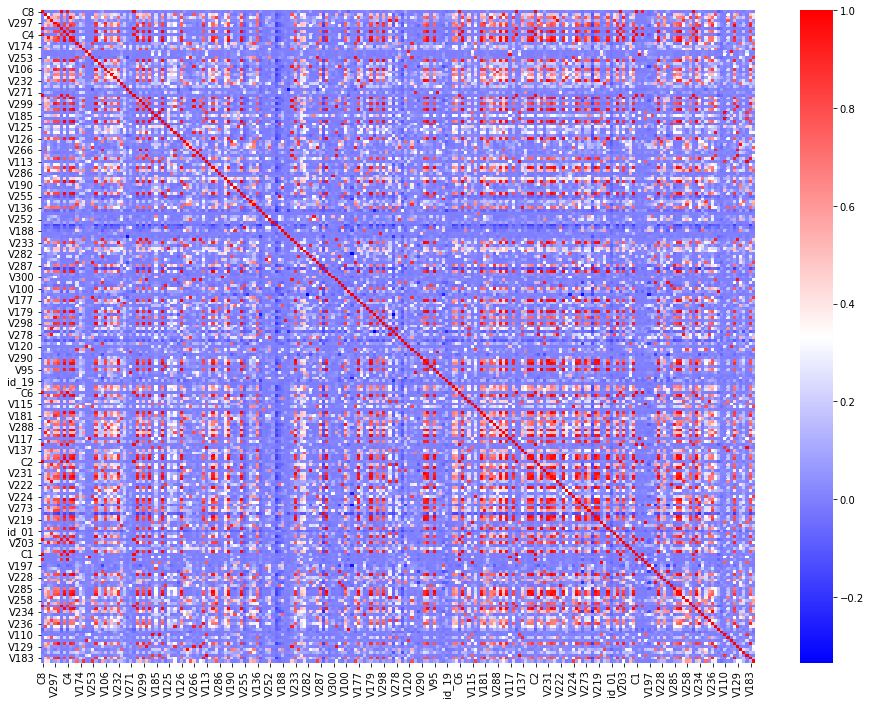

In [ ]:
corr = num_df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr, cmap='bwr', annot=False)

In [ ]:
up_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
up_tri

,C8,V130,V265,V276,V297,V180,C7,V280,C4,V204,...,V110,V135,V121,V182,V129,V242,V260,V112,V183,V267
C8,NaN,-0.004351,-0.001659,-0.002860,-0.004867,0.032492,0.980857,-0.004617,0.955632,0.021342,...,0.020674,-0.003461,0.005726,0.024980,0.001560,0.009491,-0.013319,0.024318,0.019204,-0.002525
V130,NaN,NaN,0.338896,0.049233,0.484607,0.472086,-0.006860,0.522320,-0.005405,0.528386,...,-0.004144,0.327471,0.003955,0.497417,0.617828,-0.008423,0.054768,-0.004834,0.488197,0.395175
V265,NaN,NaN,NaN,0.539263,0.526753,0.660161,-0.004865,0.650061,0.000863,0.950778,...,0.011103,0.502468,0.003041,0.675482,0.177547,0.129067,0.199362,0.006314,0.693261,0.408369
V276,NaN,NaN,NaN,NaN,0.178195,0.164203,-0.004010,0.097570,-0.001344,0.524832,...,0.002773,0.791469,0.001824,0.168094,0.027931,0.032371,0.032130,-0.001548,0.180216,0.044408
V297,NaN,NaN,NaN,NaN,NaN,0.775058,-0.010887,0.819859,-0.001980,0.760265,...,-0.009095,0.262710,-0.003732,0.816987,0.042156,-0.012905,0.155587,-0.008744,0.876684,0.078684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.256756,0.183581,0.078140,0.304298
V260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028680,0.183471,0.147366
V112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004319,-0.001517
V183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.139905


In [ ]:
# Columns having very high(> 90%) correlation - to be dropped
high_corr_col = [col for col in up_tri.columns if any(np.fabs(up_tri[col]) > 0.90)]
print("Length:", len(high_corr_col))
high_corr_col

Length: 123


['C7',
 'C4',
 'V204',
 'V295',
 'V105',
 'V106',
 'C10',
 'V212',
 'V299',
 'V102',
 'V108',
 'V97',
 'V126',
 'V266',
 'V309',
 'V293',
 'V307',
 'V190',
 'V308',
 'V256',
 'V269',
 'V233',
 'V186',
 'V124',
 'V196',
 'V239',
 'V248',
 'V316',
 'V300',
 'V311',
 'V259',
 'V100',
 'V254',
 'V177',
 'V315',
 'V179',
 'V104',
 'V292',
 'V298',
 'V216',
 'V278',
 'V120',
 'V229',
 'V270',
 'V217',
 'V178',
 'V227',
 'V95',
 'V272',
 'V195',
 'C6',
 'V128',
 'V317',
 'V199',
 'V263',
 'V99',
 'V288',
 'V213',
 'V310',
 'V168',
 'V117',
 'V275',
 'C11',
 'V111',
 'V137',
 'V101',
 'V133',
 'C2',
 'V215',
 'V132',
 'V191',
 'V231',
 'V318',
 'V202',
 'V214',
 'V222',
 'V211',
 'V224',
 'V103',
 'V218',
 'V273',
 'V235',
 'V250',
 'V167',
 'V219',
 'V114',
 'V246',
 'V306',
 'V319',
 'V296',
 'C13',
 'V203',
 'V294',
 'C1',
 'V118',
 'C14',
 'V116',
 'V197',
 'V187',
 'V134',
 'V192',
 'V221',
 'V285',
 'V279',
 'V96',
 'V277',
 'V274',
 'C12',
 'V127',
 'V234',
 'V201',
 'V320',
 'V236',
 '

In [ ]:
num_df = num_df.drop(columns=high_corr_col)
train_df = train_df.drop(columns=high_corr_col)
print(train_df.shape)

(144233, 120)


In [ ]:
imp_features = train_df.columns
imp_features

Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
       'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_20', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=120)

In [ ]:
imp_features = pd.DataFrame(imp_features)
imp_features

,0
0,isFraud
1,TransactionDT
2,TransactionAmt
3,ProductCD
4,card1
...,...
115,id_36
116,id_37
117,id_38
118,DeviceType


In [ ]:
imp_features.to_csv('/content/drive/MyDrive/DE-Project/imp_features.csv')

### Data Preprocessing

In [ ]:
# del train_transaction, train_identity

#### Selecting Important Features

In [6]:
imp_features = pd.read_csv('/content/drive/MyDrive/DE-Project/imp_features.csv', index_col=0)
imp_features

,0
0,isFraud
1,TransactionDT
2,TransactionAmt
3,ProductCD
4,card1
...,...
115,id_36
116,id_37
117,id_38
118,DeviceType


In [7]:
imp_features = imp_features.values.reshape(-1,).tolist()
imp_features

['isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'C3',
 'C8',
 'D1',
 'V98',
 'V109',
 'V113',
 'V115',
 'V119',
 'V122',
 'V123',
 'V125',
 'V130',
 'V136',
 'V169',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V180',
 'V181',
 'V184',
 'V185',
 'V188',
 'V189',
 'V193',
 'V194',
 'V198',
 'V200',
 'V205',
 'V206',
 'V207',
 'V208',
 'V209',
 'V210',
 'V220',
 'V223',
 'V225',
 'V226',
 'V228',
 'V230',
 'V232',
 'V237',
 'V238',
 'V240',
 'V241',
 'V243',
 'V244',
 'V245',
 'V247',
 'V249',
 'V251',
 'V252',
 'V253',
 'V255',
 'V257',
 'V258',
 'V260',
 'V261',
 'V262',
 'V264',
 'V265',
 'V267',
 'V268',
 'V271',
 'V276',
 'V280',
 'V281',
 'V282',
 'V283',
 'V284',
 'V286',
 'V287',
 'V289',
 'V290',
 'V291',
 'V297',
 'V301',
 'V302',
 'V303',
 'V304',
 'V312',
 'V313',
 'V314',
 'V321',
 'id_01',
 'id_02',
 'id_05',
 'id_06',
 'id_11',
 'id_12',
 'id_

In [8]:
train_df = train[imp_features]
train_df.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,credit,...,144.0,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,debit,...,500.0,New,NotFound,mobile safari 11.0,T,F,F,T,mobile,iOS Device
2,0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,credit,...,142.0,Found,Found,chrome 62.0,F,F,T,T,desktop,Windows
3,0,86555,16.495,C,4461,375.0,185.0,mastercard,224.0,debit,...,507.0,New,NotFound,chrome 62.0,F,F,T,T,desktop,NaN
4,0,86620,30.000,H,1790,555.0,150.0,visa,226.0,debit,...,575.0,Found,Found,chrome 62.0,T,F,T,T,desktop,MacOS


#### Modifying Categorical Attributes

In [9]:
modify_col_list = ['card6', 'P_emaildomain', 'R_emaildomain', 'id_31', 'DeviceInfo']

In [ ]:
# def modify_column(data, column):
#   data.loc[~data[column].isin(allowed_vals[column]), column] = "Other"

In [ ]:
# # Modify columns
# for col in modify_col_list:
#   print(f'Modify {col}')
#   print(f"Initial nunique: {train_df[col].nunique()}")
#   modify_column(train_df, col)
#   print(f"Final nunique: {train_df[col].nunique()}")
#   print()

Modify card6
Initial nunique: 3
Final nunique: 3

Modify P_emaildomain
Initial nunique: 59
Final nunique: 8

Modify R_emaildomain
Initial nunique: 60
Final nunique: 8

Modify id_31
Initial nunique: 130
Final nunique: 20

Modify DeviceInfo
Initial nunique: 1786
Final nunique: 6



/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [10]:
train_df.drop(modify_col_list, axis = 1, inplace = True)
train_df

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,C3,...,id_17,id_19,id_20,id_28,id_29,id_35,id_36,id_37,id_38,DeviceType
0,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,0.0,...,166.0,542.0,144.0,New,NotFound,T,F,T,T,mobile
1,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,0.0,...,166.0,621.0,500.0,New,NotFound,T,F,F,T,mobile
2,0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,0.0,...,121.0,410.0,142.0,Found,Found,F,F,T,T,desktop
3,0,86555,16.495,C,4461,375.0,185.0,mastercard,224.0,0.0,...,225.0,176.0,507.0,New,NotFound,F,F,T,T,desktop
4,0,86620,30.000,H,1790,555.0,150.0,visa,226.0,0.0,...,166.0,529.0,575.0,Found,Found,T,F,T,T,desktop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144228,0,15810802,48.877,C,12019,305.0,106.0,mastercard,224.0,0.0,...,225.0,427.0,139.0,Found,Found,F,F,T,F,mobile
144229,1,15810876,250.000,R,1214,174.0,150.0,visa,226.0,0.0,...,166.0,352.0,333.0,New,NotFound,T,F,T,F,mobile
144230,0,15810912,73.838,C,5096,555.0,185.0,mastercard,137.0,0.0,...,225.0,567.0,411.0,New,NotFound,F,F,T,F,mobile
144231,0,15810935,400.000,R,6019,583.0,150.0,visa,226.0,0.0,...,166.0,352.0,368.0,Found,Found,T,F,T,F,desktop


#### Filling Null Values

In [ ]:
# Attributes with missing value
train_df.isnull().any().sum()

106

In [11]:
from sklearn.impute import SimpleImputer

# Attributes with object datatype
object_df = train_df.select_dtypes(include = ["object"])
object_col = object_df.columns
print(f"No. of categorical attributes: {len(object_col)}")

# Attributes with numerical datatypes
num_col = list(set(train_df.columns) - set(object_col))
num_df = train_df[num_col]
print(f"No. of numerical attributes: {len(num_col)}")

No. of categorical attributes: 12
No. of numerical attributes: 103


In [12]:
# Filling missing values by median for numerical columns 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
num_df = pd.DataFrame(imp_median.fit_transform(num_df), columns=num_col)
print(num_df.shape)

# Filling missing values by most frequent value for categorical columns
imp_max = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
object_df = pd.DataFrame(imp_max.fit_transform(object_df), columns=object_col)
print(object_df.shape)

(144233, 103)
(144233, 12)


In [13]:
# Concatinating numerical and categorical data
combined_df = pd.concat([num_df, object_df], axis=1)
del num_df, object_df
combined_df

,V174,V198,V119,V184,V257,V244,V243,V181,V230,V171,...,id_12,id_15,id_16,id_28,id_29,id_35,id_36,id_37,id_38,DeviceType
0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,NotFound,New,NotFound,New,NotFound,T,F,T,T,mobile
1,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,NotFound,New,NotFound,New,NotFound,T,F,F,T,mobile
2,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,...,NotFound,Found,Found,Found,Found,F,F,T,T,desktop
3,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,NotFound,New,NotFound,New,NotFound,F,F,T,T,desktop
4,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,NotFound,Found,Found,Found,Found,T,F,T,T,desktop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144228,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,8.0,10.0,...,NotFound,Found,Found,Found,Found,F,F,T,F,mobile
144229,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,NotFound,New,NotFound,New,NotFound,T,F,T,F,mobile
144230,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,NotFound,New,NotFound,New,NotFound,F,F,T,F,mobile
144231,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,NotFound,Found,Found,Found,Found,T,F,T,F,desktop


In [14]:
combined_df.isnull().any().sum()

0

#### One-Hot Encoding

In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder(handle_unknown = 'ignore', sparse=False)

# encoder.fit(combined_df)
# encoder.transform(combined_df)
# combined_df

In [15]:
encoded_df = pd.get_dummies(combined_df, columns = object_col)
encoded_df

,V174,V198,V119,V184,V257,V244,V243,V181,V230,V171,...,id_35_F,id_35_T,id_36_F,id_36_T,id_37_F,id_37_T,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile
0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0,1,1,0,0,1,0,1,0,1
1,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0,1,1,0,1,0,0,1,0,1
2,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,...,1,0,1,0,0,1,0,1,1,0
3,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1,0,1,0,0,1,0,1,1,0
4,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0,1,1,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144228,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,8.0,10.0,...,1,0,1,0,0,1,1,0,0,1
144229,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0,1,1,0,0,1,1,0,0,1
144230,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1,0,1,0,0,1,1,0,0,1
144231,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0,1,1,0,0,1,1,0,1,0


#### x_train, y_train

In [16]:
x_train = encoded_df.drop(columns = ['isFraud'])
y_train = encoded_df['isFraud']
print(x_train.shape)

(144233, 131)


#### Class Imbalance

In [ ]:
y_train.value_counts()

0.0    132915
1.0     11318
Name: isFraud, dtype: int64

In [ ]:
y_train.value_counts()/len(y_train)*100

0.0    92.152975
1.0     7.847025
Name: isFraud, dtype: float64

In [17]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42, sampling_strategy = 0.6)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel())

print('After OverSampling, shape of train_X: {}'.format(x_train_res.shape))
print('After OverSampling, shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))

After OverSampling, shape of train_X: (212664, 131)
After OverSampling, shape of train_y: (212664,) 

After OverSampling, counts of label '0': 132915
After OverSampling, counts of label '1': 79749


In [ ]:
x_train_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212664 entries, 0 to 212663
Columns: 131 entries, V297 to DeviceType_mobile
dtypes: float64(102), uint8(29)
memory usage: 171.4 MB


#### Scaling

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(x_train_res)
x_s = scaler.fit_transform(x_train_res)
x_scaled = pd.DataFrame(x_s)
x_scaled

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,0.000000,0.047619,0.333333,0.0000,0.020833,0.045455,0.017544,0.000000,0.015385,0.016393,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.000000,0.047619,0.333333,0.0000,0.020833,0.045455,0.017544,0.000000,0.015385,0.016393,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,0.250000,0.047619,0.333333,0.0625,0.020833,0.045455,0.017544,0.041667,0.061538,0.065574,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.000000,0.047619,0.333333,0.0000,0.020833,0.045455,0.017544,0.000000,0.015385,0.016393,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.000000,0.047619,0.333333,0.0000,0.020833,0.045455,0.017544,0.000000,0.015385,0.016393,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212659,0.000000,0.047619,0.333333,0.0000,0.037090,0.045455,0.017544,0.000000,0.015385,0.032787,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
212660,0.000000,0.047619,0.333333,0.0090,0.026834,0.052000,0.020070,0.006000,0.055016,0.023476,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
212661,0.000000,0.043698,0.333333,0.0000,0.020833,0.045455,0.017544,0.000000,0.029502,0.015043,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
212662,0.125000,0.051328,0.333333,0.0625,0.020833,0.045455,0.017544,0.003246,0.015385,0.050457,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


### Test Data - Transforming

#### Loading

In [ ]:
test_transaction = pd.read_csv('/content/drive/MyDrive/DE-Project/ieee-fraud-detection/test_transaction.csv')
test_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 393 entries, TransactionID to V339
dtypes: float64(376), int64(3), object(14)
memory usage: 1.5+ GB


In [ ]:
train_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [ ]:
test_identity = pd.read_csv('/content/drive/MyDrive/DE-Project/ieee-fraud-detection/test_identity.csv')
test_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141907 entries, 0 to 141906
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  141907 non-null  int64  
 1   id-01          141907 non-null  float64
 2   id-02          136976 non-null  float64
 3   id-03          66481 non-null   float64
 4   id-04          66481 non-null   float64
 5   id-05          134750 non-null  float64
 6   id-06          134750 non-null  float64
 7   id-07          5059 non-null    float64
 8   id-08          5059 non-null    float64
 9   id-09          74338 non-null   float64
 10  id-10          74338 non-null   float64
 11  id-11          136778 non-null  float64
 12  id-12          141907 non-null  object 
 13  id-13          130286 non-null  float64
 14  id-14          71357 non-null   float64
 15  id-15          136977 non-null  object 
 16  id-16          125747 non-null  object 
 17  id-17          135966 non-nul

In [ ]:
train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [ ]:
# Replacing '-' in features names with '_'
test_identity.columns = test_identity.columns.str.replace(r"[-]", "_")

<ipython-input-28-25e997a24505>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_identity.columns = test_identity.columns.str.replace(r"[-]", "_")


In [ ]:
test_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141907 entries, 0 to 141906
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  141907 non-null  int64  
 1   id_01          141907 non-null  float64
 2   id_02          136976 non-null  float64
 3   id_03          66481 non-null   float64
 4   id_04          66481 non-null   float64
 5   id_05          134750 non-null  float64
 6   id_06          134750 non-null  float64
 7   id_07          5059 non-null    float64
 8   id_08          5059 non-null    float64
 9   id_09          74338 non-null   float64
 10  id_10          74338 non-null   float64
 11  id_11          136778 non-null  float64
 12  id_12          141907 non-null  object 
 13  id_13          130286 non-null  float64
 14  id_14          71357 non-null   float64
 15  id_15          136977 non-null  object 
 16  id_16          125747 non-null  object 
 17  id_17          135966 non-nul

In [ ]:
test = pd.merge(test_transaction, test_identity, on='TransactionID')
test

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,18404013,6.271,C,15885,545.0,185.0,visa,138.0,debit,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,18404055,50.000,S,2453,399.0,150.0,american express,137.0,credit,...,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,18404235,37.318,C,15885,545.0,185.0,visa,138.0,debit,...,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,18404315,6.271,C,15885,545.0,185.0,visa,138.0,debit,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,18404359,52.258,C,9633,130.0,185.0,visa,138.0,debit,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141902,4170230,34214253,10.452,C,5812,408.0,185.0,mastercard,224.0,debit,...,chrome 71.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-J700M
141903,4170233,34214271,13.403,C,3154,408.0,185.0,mastercard,224.0,debit,...,chrome 71.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-J320M
141904,4170234,34214277,50.000,H,9002,453.0,150.0,visa,226.0,debit,...,mobile safari 10.0,32.0,1334x750,match_status:2,T,F,F,T,mobile,iOS Device
141905,4170236,34214287,12.173,C,3154,408.0,185.0,mastercard,224.0,debit,...,chrome 43.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,ALE-L23 Build/HuaweiALE-L23


In [ ]:
print(test.columns[train.drop(columns = ['isFraud']).columns != test.columns])

Index([], dtype='object')


#### Transforming

In [ ]:
test_imp_features = filter(lambda x: x != 'isFraud', imp_features)
test_df = test[test_imp_features]

# Modify columns
# for col in modify_col_list:
#   print(f'Modify {col}')
#   print(f"Initial nunique: {test_df[col].nunique()}")
#   modify_column(test_df, col)
#   print(f"Final nunique: {test_df[col].nunique()}")
#   print()

test_df.drop(modify_col_list, axis = 1, inplace = True)

from sklearn.impute import SimpleImputer

# Attributes with object datatype
object_df = test_df.select_dtypes(include = ["object"])
object_col = object_df.columns
print(f"No. of categorical attributes: {len(object_col)}")

# Attributes with numerical datatypes
num_col = list(set(test_df.columns) - set(object_col))
num_df = test_df[num_col]
print(f"No. of numerical attributes: {len(num_col)}")

# Filling missing values by median for numerical columns 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
num_df = pd.DataFrame(imp_median.fit_transform(num_df), columns=num_col)
print(num_df.shape)

# Filling missing values by most frequent value for categorical columns
imp_max = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
object_df = pd.DataFrame(imp_max.fit_transform(object_df), columns=object_col)
print(object_df.shape)

# Concatinating numerical and categorical data
combined_df = pd.concat([num_df, object_df], axis=1)
del num_df, object_df

encoded_df = pd.get_dummies(combined_df, columns = object_col)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(encoded_df)
x_s = scaler.fit_transform(encoded_df)
x_test_scaled = pd.DataFrame(x_s)
x_test_scaled

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


No. of categorical attributes: 12
No. of numerical attributes: 102
(141907, 102)
(141907, 12)


,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,0.0,0.090909,0.25,0.0,0.826786,0.0,0.000000,0.015873,0.000000,0.022727,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,0.0,0.090909,0.25,0.0,0.478571,0.0,0.053125,0.015873,0.000000,0.022727,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.0,0.090909,0.25,0.0,0.726786,0.0,0.000000,0.015873,0.000000,0.022727,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0.0,0.090909,0.25,0.0,0.826786,0.0,0.000000,0.031746,0.005587,0.022727,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,0.0,0.090909,0.25,0.0,0.726786,0.0,0.000000,0.015873,0.000000,0.022727,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141902,0.0,0.090909,0.25,0.0,0.401786,0.0,0.000000,0.015873,0.000000,0.022727,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
141903,0.0,0.090909,0.25,0.0,0.883929,0.0,0.582813,0.000000,0.000000,0.000000,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
141904,0.0,0.090909,0.25,0.0,0.137500,0.0,0.000000,0.015873,0.000000,0.022727,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
141905,0.0,0.090909,0.25,0.0,0.726786,0.0,0.025000,0.015873,0.000000,0.022727,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


### Modeling

In [28]:
import mlflow

with mlflow.start_run(run_name="MLflow on Colab"):
  mlflow.log_metric("m1", 2.0)
  mlflow.log_param("p1", "mlflow-colab")

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "<NGROK_AUTH_TOKEN>"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://39d3-35-194-238-172.ngrok.io


#### Train Validate Split

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_scaled, y_train_res, test_size=0.2, random_state=42)

#### Random Forest Classifier

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from urllib.parse import urlparse

def eval_metrics(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  return accuracy, precision, recall, f1

with mlflow.start_run(run_name="RandomForest"):
  rf_classify = RandomForestClassifier(criterion = 'gini', max_depth = None, min_samples_split = 2, random_state = 42)
  rf_classify.fit(X_train, Y_train)

  rf_pred = rf_classify.predict(X_test)

  (accuracy, precision, recall, f1) = eval_metrics(Y_test, rf_pred)

  print("Accuracy: %s" % accuracy)
  print("Precision: %s" % precision)
  print("Recall: %s" % recall)
  print("F1_Score: %s" % f1)

  mlflow.log_param("criterion", 'gini')
  mlflow.log_param("max_depth", None)
  mlflow.log_param("min_samples_split", 2)
  mlflow.log_param("random_state", 42)
  mlflow.log_metric("Accuracy", accuracy)
  mlflow.log_metric("Precision", precision)
  mlflow.log_metric("Recall", recall)
  mlflow.log_metric("F1_Score", f1)

  tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

  if tracking_url_type_store != "file":
      mlflow.sklearn.log_model(rf_classify, "model", registered_model_name="RandomForest")
  else:
      mlflow.sklearn.log_model(rf_classify, "model")

Accuracy: 0.9741142171960595
Precision: 0.9913123601421614
Recall: 0.9395546129374337
F1_Score: 0.9647397918334668


In [ ]:
pkl.dump(rf_classify, open('/content/drive/MyDrive/DE-Project/rf_classify.pkl', 'wb'))

#### ANN

In [24]:
import tensorflow as tf

with mlflow.start_run(run_name="ANN"):
  ann_model = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(131,)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(2, activation='softmax')
  ])

  ann_model.compile(
      optimizer='adam',
      loss = 'sparse_categorical_crossentropy',
      metrics = ['accuracy']
  )

  callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0.0001,
    patience=3,
  )

  ann_model.fit(X_train, Y_train, epochs=150, callbacks=[callback])

  ann_pred = ann_model.predict(X_test)

  pred = [np.argmax(x) for x in ann_pred]
  (accuracy, precision, recall, f1) = eval_metrics(Y_test, pred)

  print("Accuracy: %s" % accuracy)
  print("Precision: %s" % precision)
  print("Recall: %s" % recall)
  print("F1_Score: %s" % f1)

  mlflow.log_param("optimizer", 'adam')
  mlflow.log_param("loss", 'sparse_categorical_crossentropy')
  mlflow.log_param("metrics", 'accuracy')
  mlflow.log_param("epochs", 150)
  mlflow.log_param("callback", 'min_delta=0.0001')
  mlflow.log_metric("Accuracy", accuracy)
  mlflow.log_metric("Precision", precision)
  mlflow.log_metric("Recall", recall)
  mlflow.log_metric("F1_Score", f1)

  tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

  if tracking_url_type_store != "file":
      mlflow.sklearn.log_model(ann_model, "model", registered_model_name="ANN_Model")
  else:
      mlflow.sklearn.log_model(ann_model, "model")

Epoch 1/150
5317/5317 [==============================] - 13s 2ms/step - loss: 0.1875 - accuracy: 0.9337
Epoch 2/150
5317/5317 [==============================] - 12s 2ms/step - loss: 0.1562 - accuracy: 0.9461
Epoch 3/150
5317/5317 [==============================] - 12s 2ms/step - loss: 0.1471 - accuracy: 0.9491
Epoch 4/150
5317/5317 [==============================] - 12s 2ms/step - loss: 0.1424 - accuracy: 0.9507
Epoch 5/150
5317/5317 [==============================] - 14s 3ms/step - loss: 0.1375 - accuracy: 0.9526
Epoch 6/150
5317/5317 [==============================] - 12s 2ms/step - loss: 0.1339 - accuracy: 0.9533
Epoch 7/150
5317/5317 [==============================] - 12s 2ms/step - loss: 0.1304 - accuracy: 0.9546
Epoch 8/150
5317/5317 [==============================] - 12s 2ms/step - loss: 0.1280 - accuracy: 0.9562
Epoch 9/150
5317/5317 [==============================] - 12s 2ms/step - loss: 0.1255 - accuracy: 0.9565
Epoch 10/150
5317/5317 [==============================] - 12s 2m

2022/12/25 18:06:31 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.25+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLflow logged a pip requirement for this package as 'jaxlib==0.3.25' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [ ]:
pkl.dump(ann_model, open('/content/drive/MyDrive/DE-Project/ann_model.pkl', 'wb'))

In [ ]:
ann_pred = ann_model.predict(X_test)
ann_pred

1330/1330 [==============================] - 6s 4ms/step


array([[9.7342461e-01, 2.6575413e-02],
       [9.9992281e-01, 7.7123746e-05],
       [2.6802327e-02, 9.7319764e-01],
       ...,
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [7.6110281e-15, 1.0000000e+00]], dtype=float32)

In [ ]:
pred = [np.argmax(x) for x in ann_pred]
ann_acc = accuracy_score(Y_test, pred)
ann_acc

0.9657442456445583

#### Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression

with mlflow.start_run(run_name="LogisticRegression"):
  lr_classify = LogisticRegression(solver = "saga", penalty = "elasticnet", random_state = 42, multi_class = "auto", l1_ratio = 0.9)
  
  lr_classify.fit(X_train, Y_train)

  lr_pred = lr_classify.predict(X_test)

  (accuracy, precision, recall, f1) = eval_metrics(Y_test, lr_pred)

  print("Accuracy: %s" % accuracy)
  print("Precision: %s" % precision)
  print("Recall: %s" % recall)
  print("F1_Score: %s" % f1)

  mlflow.log_param("solver", "saga")
  mlflow.log_param("penalty", "elasticnet")
  mlflow.log_param("l1_ratio", 0.9)
  mlflow.log_param("random_state", 42)
  mlflow.log_metric("Accuracy", accuracy)
  mlflow.log_metric("Precision", precision)
  mlflow.log_metric("Recall", recall)
  mlflow.log_metric("F1_Score", f1)

  tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

  if tracking_url_type_store != "file":
      mlflow.sklearn.log_model(lr_classify, "model", registered_model_name="LogisticRegression")
  else:
      mlflow.sklearn.log_model(lr_classify, "model")

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy: 0.9418098887922319
Precision: 0.9747828523395909
Recall: 0.8680681180213337
F1_Score: 0.918335698023559


In [ ]:
pkl.dump(lr_classify, open('/content/drive/MyDrive/DE-Project/lr_classify.pkl', 'wb'))